In [1]:
import os
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dists

import matplotlib; # matplotlib.use('Agg')  # Allows to create charts with undefined $DISPLAY
%matplotlib inline
import matplotlib.pyplot as plt

from model import FullyConnected, BayesianRegression
from viz import get_coverage_bounds, plot_1d_posterior_predictive, get_uncertainty_in_gap, plot_basis_functions_1d
from util import *

# define model
w_prior_var = 1.0 # variance of prior over weights
output_var = 0.01 # variance of observation noise
model = BayesianRegression(w_prior_var, output_var)

# set training data
N = 20
# x_train = dists.Uniform(-1.0, -0.5).sample((N/2, 1))
x_train = torch.cat((dists.Uniform(-1.0, -0.2).sample((N//2, 1)), dists.Uniform(0.2, 1).sample((N//2, 1))))
y_train = add_output_noise(torch.pow(x_train, 3.0), output_var)

# parameters of optimizer
LEARNING_RATE = 0.001 
EPOCHS = 50000

# architecture and activation
ACTIVATION = nn.ReLU
num_final_layers = 24
layers = [1, 144, 24, num_final_layers, 1]

# define a neural network feature basis and final layer
basis = FullyConnected(layers[:-1], activation_module=ACTIVATION, output_activation=True)
final_layer = FullyConnected(layers[-2:], activation_module=ACTIVATION)

# define MLE loss
def mle_loss():
    y_pred = final_layer(basis(x_train))
    loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1))
    
    return loss, (basis, final_layer)

# randomly initialize basis and last layer
basis.rand_init(math.sqrt(w_prior_var))
final_layer.rand_init(math.sqrt(w_prior_var))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/__init__.py:149: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.3
  UserWarning)


In [2]:
# optimize loss to learn network
(basis, final_layer), loss = train_objective(
    list(basis.parameters()) + list(final_layer.parameters()),
    mle_loss,
    lr=LEARNING_RATE,
    print_freq=1000
)

Epoch 0: loss = 4962.218921090964
Epoch 1000: loss = 0.025469427583609133
Epoch 2000: loss = 0.014567224306211232
Epoch 3000: loss = 0.013000884736256685
Epoch 4000: loss = 0.011436627843168281
Final Loss = 0.009516595096132261


In [3]:
# infer posterior over the last layer weights given the basis
posterior, posterior_mean = model.infer_posterior(basis(x_train), y_train)

In [4]:
# calculate the area in between the training data points
def uncertainty_area(upper, lower, h):
    """
    Calculate the area between f1 and f2 over the interval [x1, x2] using n points in finite estimation
    """
    return np.sum(np.abs(upper - lower)) * h

def get_uncertainty_in_gap(model, basis, x_train, y_train, n_points, picp=95.0):
    assert(len(x_train.shape) == 2 and x_train.shape[-1] == 1)
    assert(len(y_train.shape) == 2 and y_train.shape[-1] == 1)

    # make sure x_train is sorted in ascending order
    x_train_sorted = np.sort(to_np(x_train.squeeze()))
    assert(np.all(x_train_sorted[:-1] <= x_train_sorted[1:]))

    # find gap
    N = len(x_train)
    gap = np.linspace(x_train_sorted.squeeze()[N//2-1], x_train_sorted.squeeze()[N//2], n_points)
    h = gap[1] - gap[0]
    gap = ftens_cuda(gap).unsqueeze(-1)
    
    # sample from inside gap
    y_pred = model.sample_posterior_predictive(basis(gap), n_points)
    lower, upper = get_coverage_bounds(to_np(y_pred), picp)
    
    area = uncertainty_area(upper, lower, h)

    return area

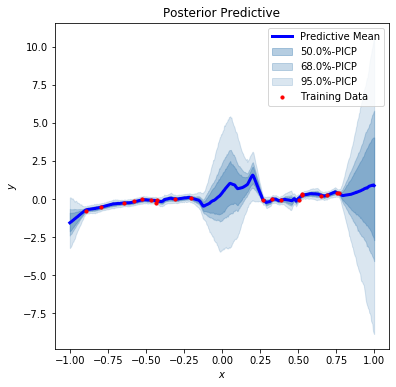

Uncertainty area: 1.9219534168391688


In [5]:
# # sample from posterior predictive
x_viz = ftens_cuda(np.linspace(-1.0, 1.0, 500)).unsqueeze(-1)
y_pred = model.sample_posterior_predictive(basis(x_viz), 500)

# visualize posterior predictive
%matplotlib inline
plot_1d_posterior_predictive(x_train, y_train, x_viz, y_pred)
print(f"Uncertainty area: {get_uncertainty_in_gap(model, basis, x_train, y_train, 500)}")

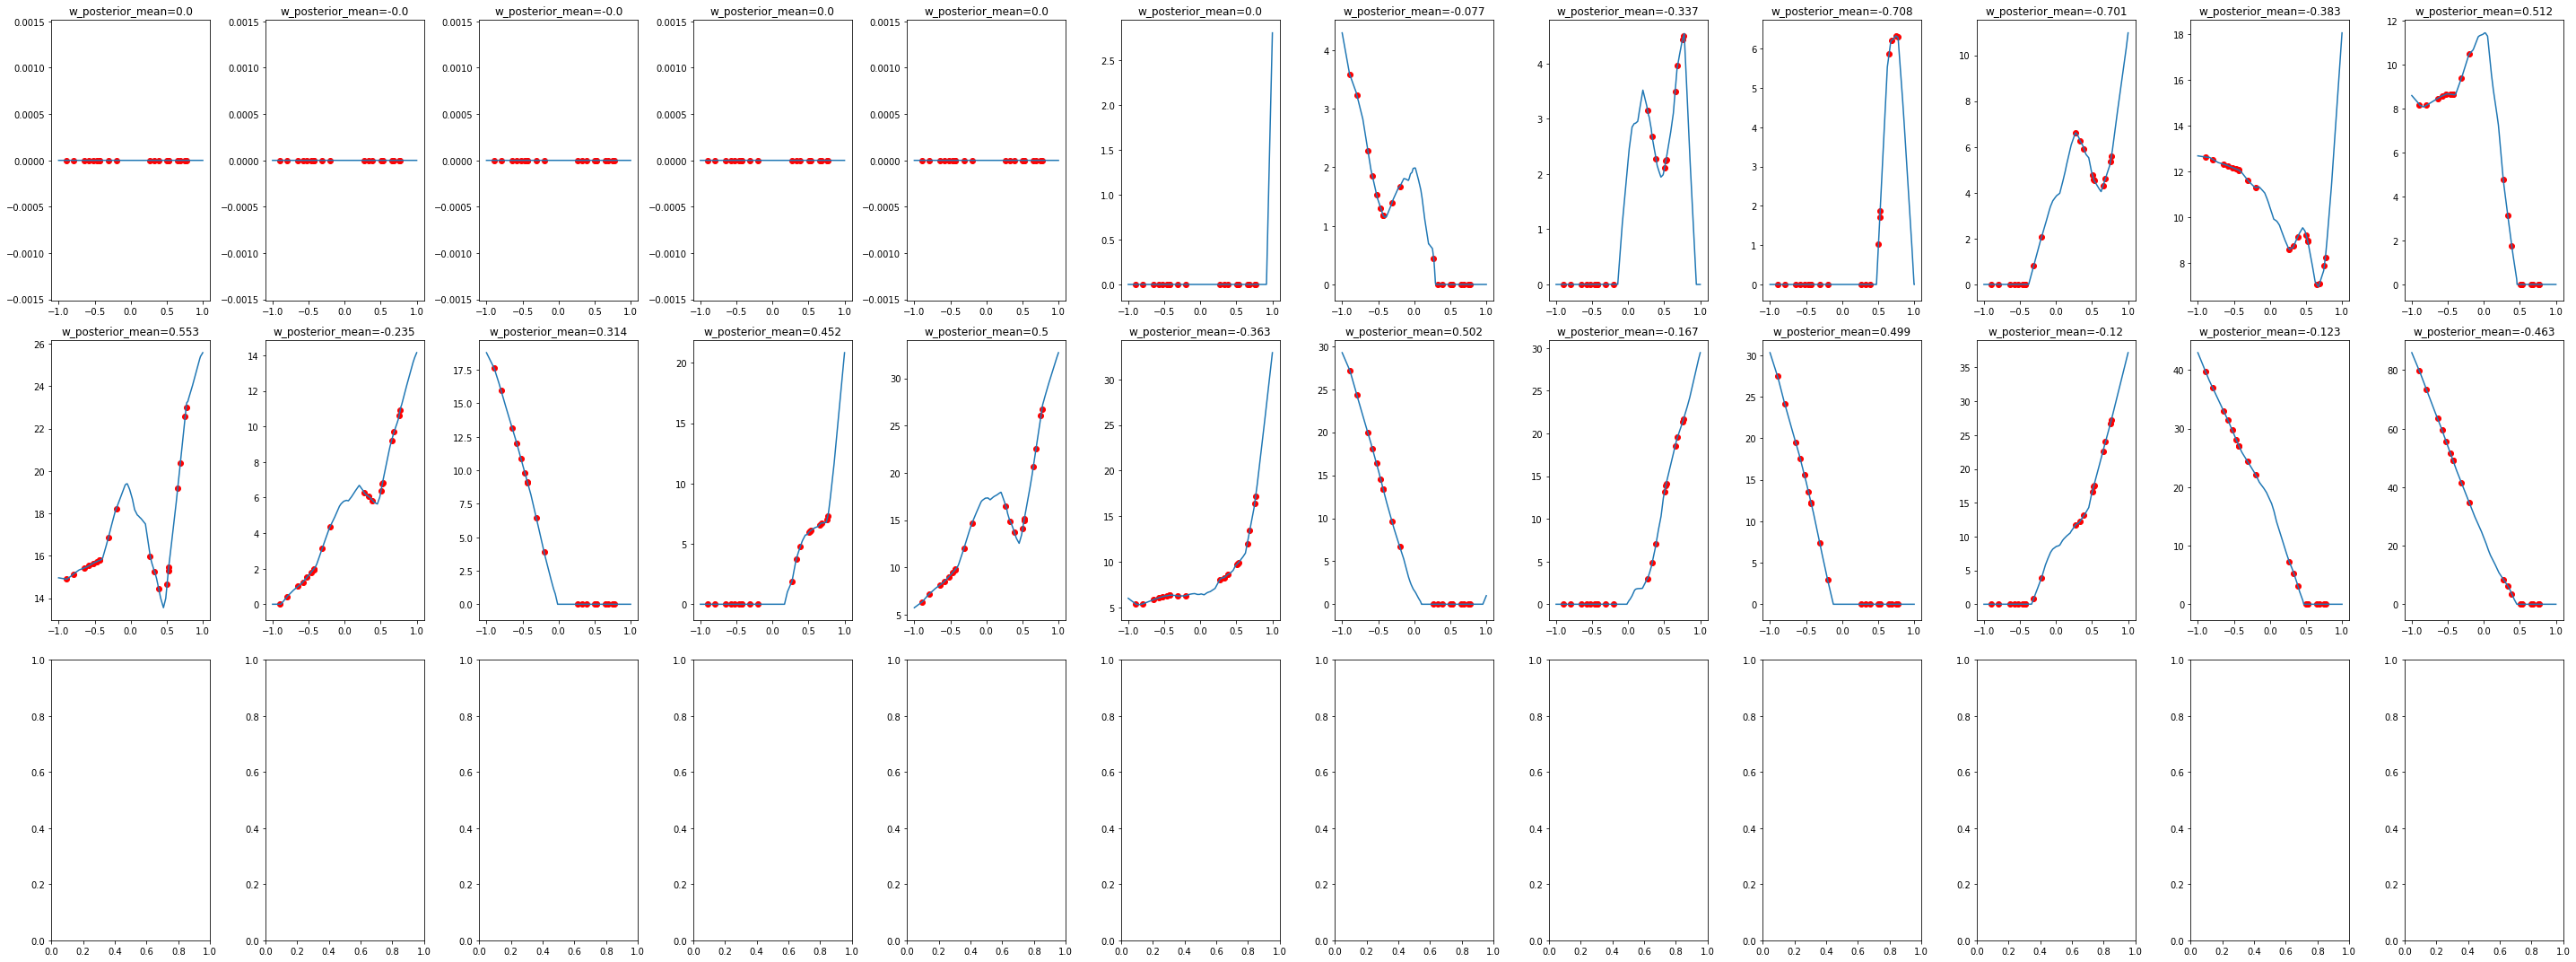

In [6]:
x_vals = np.linspace(-1, 1, 3000)
basis_vals = plot_basis_functions_1d(num_final_layers, x_vals, basis, x_train, posterior_mean, numcols=12)

In [7]:
import pandas as pd

# each column is a basis function
basis_vals_np = basis_vals.detach().cpu().numpy()
basis_vals_df = pd.DataFrame(basis_vals_np)
basis_vals_df.head()

0    1         2          3    4          5         6    7    8    9   \
0  0.0  0.0  8.595377  30.292397  0.0  18.781803  5.740918  0.0  0.0  0.0   
1  0.0  0.0  8.592887  30.274472  0.0  18.774457  5.744627  0.0  0.0  0.0   
2  0.0  0.0  8.590397  30.256546  0.0  18.767110  5.748336  0.0  0.0  0.0   
3  0.0  0.0  8.587907  30.238621  0.0  18.759764  5.752045  0.0  0.0  0.0   
4  0.0  0.0  8.585417  30.220695  0.0  18.752417  5.755754  0.0  0.0  0.0   

   ...         14   15        16   17         18   19         20   21  \
0  ...  14.963122  0.0  6.007477  0.0  42.957661  0.0  85.975475  0.0   
1  ...  14.962703  0.0  6.003399  0.0  42.937416  0.0  85.936523  0.0   
2  ...  14.962284  0.0  5.999320  0.0  42.917170  0.0  85.897572  0.0   
3  ...  14.961866  0.0  5.995242  0.0  42.896925  0.0  85.858621  0.0   
4  ...  14.961447  0.0  5.991163  0.0  42.876680  0.0  85.819670  0.0   

          22   23  
0  12.696909  0.0  
1  12.696547  0.0  
2  12.696184  0.0  
3  12.695822  0.0  
4  12.695459  0.0  

[5 rows x 24 columns]

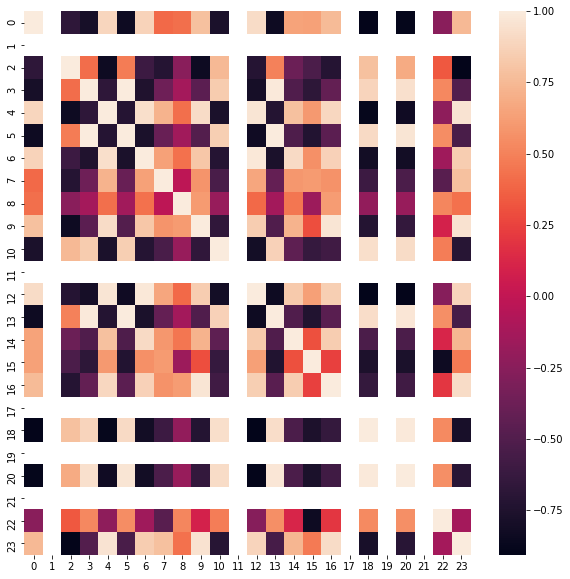

In [8]:
import seaborn as sns

corr = basis_vals_df.corr()

plt.figure(figsize=(10,10))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

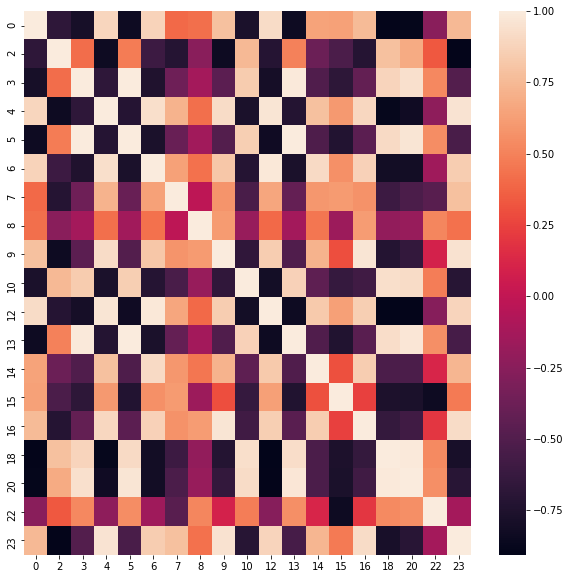

In [9]:
# drop irrelevant rows/columns
corr.dropna(axis=0, how='all', inplace=True)
corr.dropna(axis=1, how='all', inplace=True)

plt.figure(figsize=(10,10))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

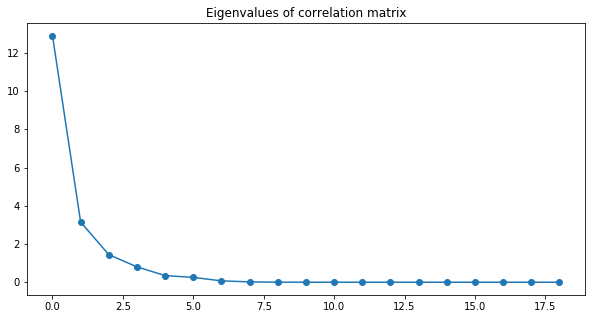

In [11]:
evals, evecs = np.linalg.eig(corr)

plt.figure(figsize=(10, 5))
plt.scatter(np.arange(len(evals)), evals)
plt.plot(evals)
plt.title("Eigenvalues of correlation matrix")
plt.show()

In [12]:
def eff_dim(evals, z):
    assert z > 0
    return np.sum(np.divide(evals, evals+z))

In [13]:
eff_dim(evals, 1)

3.278065193916457

Epoch 0: loss = 7.009736275093635
Epoch 1000: loss = 0.017998171235295662
Epoch 2000: loss = 0.012435265299948109
Epoch 3000: loss = 0.011281946241369589
Epoch 4000: loss = 0.011005448189337326
Final Loss = 0.010832882000408084


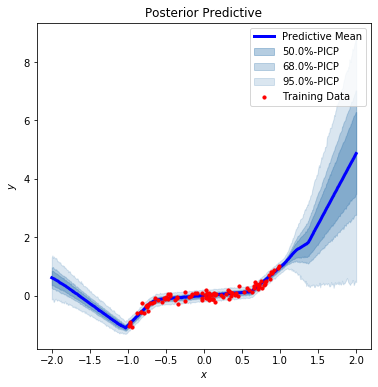

Epoch 0: loss = 459.99309894443417
Epoch 1000: loss = 0.024426195491771517
Epoch 2000: loss = 0.013151515417294828
Epoch 3000: loss = 0.009752860227241452
Epoch 4000: loss = 0.008505335771170281
Final Loss = 0.007746398098612602


Epoch 0: loss = 1303.6038516699143
Epoch 1000: loss = 0.026074579660693136
Epoch 2000: loss = 0.01395337245820421
Epoch 3000: loss = 0.006794404035194942
Epoch 4000: loss = 0.005962291772878394
Final Loss = 0.005505219302638206


In [14]:
# run nlm on small/ large models and compare uncertainties
def nlm(w_prior_var = 1.0,output_var = 0.01, LEARNING_RATE = 0.001, EPOCHS = 20000, layers = [1, 50, 50, 1] ):
    # if not os.path.exists(OUTPUT_DIR):
    #     os.makedirs(OUTPUT_DIR)
        
    # define model
    #w_prior_var = 1.0 # variance of prior over weights
    #output_var = 0.01 # variance of observation noise
    model = BayesianRegression(w_prior_var, output_var)
    
    # set training data
    N = 100
    x_train = dists.Uniform(-1.0, 1.0).sample((N, 1))
    y_train = add_output_noise(torch.pow(x_train, 3.0), output_var)
    
    # parameters of optimizer
    # LEARNING_RATE = 0.001
    # EPOCHS = 20000

    # architecture and activation
    ACTIVATION = nn.LeakyReLU
    #layers = [1, 50, 50, 1]
    
    # define a neural network feature basis and final layer
    basis = FullyConnected(layers[:-1], activation_module=ACTIVATION, output_activation=True)
    final_layer = FullyConnected(layers[-2:], activation_module=ACTIVATION)

    # define MLE loss
    def mle_loss():
        y_pred = final_layer(basis(x_train))
        loss = torch.mean(torch.sum(torch.pow(final_layer(basis(x_train)) - y_train, 2.0), -1))
        
        return loss, (basis, final_layer)

    # randomly initialize basis and last layer
    basis.rand_init(math.sqrt(w_prior_var))
    final_layer.rand_init(math.sqrt(w_prior_var))

    # optimize loss to learn network
    (basis, final_layer), loss = train_objective(
        list(basis.parameters()) + list(final_layer.parameters()),
        mle_loss,
        lr=LEARNING_RATE,
        print_freq=1000
    )

    # infer posterior over the last layer weights given the basis
    model.infer_posterior(basis(x_train), y_train)

    # sample from posterior predictive
    x_viz = ftens_cuda(np.linspace(-2.0, 2.0, 500)).unsqueeze(-1)
    y_pred = model.sample_posterior_predictive(basis(x_viz), 500)

    # visualize posterior predictive
    plot_1d_posterior_predictive(x_train, y_train, x_viz, y_pred)

layers_choices = [[1,8,8,1],[1, 50, 50, 1], [1,128,128,1] ]

for layer_structure in layers_choices:
    nlm(layers = layer_structure)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c42157bc-f2b8-432a-aeaf-313aea189abc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>